In [55]:
import sys,os
import matplotlib as mpl
from matplotlib.path import Path
import matplotlib.patches as patches
import matplotlib.patheffects as pe
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import vaex
import astropy.units as u
import scipy.stats
from math import ceil
import reverse_indices_2d as ri
from astroquery.ipac.irsa import Irsa
from astropy.coordinates import SkyCoord
from astropy import units as u
from scipy.optimize import curve_fit
from scipy import stats
from scipy.stats import gaussian_kde

%matplotlib inline

In [46]:
run ../scripts/rc_params.py

rcParams updated :)


<Figure size 504x504 with 0 Axes>

In [5]:
#Create a dataframe of PHATTER sources
#First cut to the data is GST criteria for the IR filters

phatter = vaex.open('/Users/tatianasandford/Documents/Research/M33/M33_full_matched.hdf5')
phatter.select('(F110W_SNR > 4) & (F110W_SHARP**2 < 0.15) & '
          '(F110W_CROWD < 2.25) & '
          '(F160W_SNR > 4) & (F160W_SHARP**2 < 0.15) & '
          '(F160W_CROWD < 2.25)', name='IR_GST')

In [6]:
# Set the aspect ratio for any ra/dec plot of M33

ra_max, ra_min = phatter.RA.max(selection='IR_GST'), phatter.RA.min(selection='IR_GST')
dec_max, dec_min = phatter.DEC.max(selection='IR_GST'), phatter.DEC.min(selection='IR_GST')
dec_m33 = phatter.DEC.mean()

m33_ar = (dec_max - dec_min) / ((ra_max - ra_min)*np.cos(np.pi/180.*dec_m33))

In [18]:
print('Coordinate Span of PHATTER footprint')
print('RA (deg): {:.3f} - {:.3f}'.format(ra_min, ra_max))
print('DEC (deg): {:.3f} - {:.3f}'.format(dec_min, dec_max))

Coordinate Span of PHATTER footprint
RA (deg): 23.342 - 23.661
DEC (deg): 30.489 - 30.849


In [24]:
#Create a table of unWISE sources within the PHATTER footprint

Irsa.ROW_LIMIT = 100000
wise = Irsa.query_region("m33", catalog="unwise_2019", spatial="Polygon",
            polygon=[SkyCoord(ra=23.341,dec=30.488,unit=(u.deg,u.deg),frame='icrs'),
                     SkyCoord(ra=23.662,dec=30.488,unit=(u.deg,u.deg),frame='icrs'),
                     SkyCoord(ra=23.662,dec=30.85,unit=(u.deg,u.deg),frame='icrs'),
                     SkyCoord(ra=23.341,dec=30.85,unit=(u.deg,u.deg),frame='icrs')])

wise[:2]

unwise_objid,ra,dec,clon,clat,x_1,dx_1,x_2,dx_2,y_1,dy_1,y_2,dy_2,flux_1,dflux_1,flux_2,dflux_2,fluxlbs_1,dfluxlbs_1,fluxlbs_2,dfluxlbs_2,qf_1,qf_2,rchi2_1,rchi2_2,fracflux_1,fracflux_2,spread_model_1,dspread_model_1,spread_model_2,dspread_model_2,fwhm_1,fwhm_2,sky_1,sky_2,nm_1,nm_2,primary_1,primary_2,primary,flags_unwise_1,flags_unwise_2,flags_info_1,flags_info_2,coadd_id,unwise_detid_1,unwise_detid_2
,deg,deg,,,pix,pix,pix,pix,pix,pix,pix,pix,'nMgy','nMgy','nMgy','nMgy','nMgy','nMgy','nMgy','nMgy',,,,,,,,,,,pix,pix,'nMgy','nMgy',,,,,,,,,,,,
object,float64,float64,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,int32,int32,int32,int32,int32,int32,int32,object,object,object
0243p302o0017123,23.62794233,30.48854987,01h34m30.71s,30d29m18.78s,1287.4643,0.02724,1287.4427,0.11599,1835.6880,0.02823,1835.9147,0.11412,539.8800,8.8048,477.9500,29.6750,512.8600,8.9965,446.1800,30.4630,1.000,1.000,15.084,1.254,0.88,0.90,0.008,0.0006,0.010,0.0024,2.624,2.846,13.5,8.9,127,127,1,1,1,0,0,66,66,0243p302,0243p302w1o0027393,0243p302w2o0016553
0243p302o0017136,23.63701125,30.48934148,01h34m32.88s,30d29m21.63s,1288.4358,0.01091,1288.4726,0.04059,1825.4499,0.01131,1825.3690,0.03993,1448.6000,10.2680,1405.2000,31.5860,1409.2000,10.4690,1382.7000,32.3850,1.000,1.000,9.264,0.502,0.99,0.99,0.001,0.0003,0.000,0.0009,2.625,2.850,11.8,7.7,124,126,1,1,1,0,0,66,66,0243p302,0243p302w1o0027419,0243p302w2o0016565


In [26]:
#Cut any unWISE source with the flag 'primary' not equal to 1
#This will elminate duplicate sources
dup_cut, = np.where(wise['primary'] == 1)

#Convert entries with no W1 flux measurement to 0.0
uw = wise.filled(fill_value=0.0)

#Define the culled dataframe
unwise = uw[dup_cut][uw[dup_cut]['flux_1'] != 0]

#Add an index to more easily reference specific sources
unwise['index'] = np.arange(len(unwise))

In [27]:
#Converts flux measurements to vega magnitude, valid for W1 and W2
#Conversion from 'The unWISE Catalog: Two Billion Infrared Sources from Five Years of WISE Imaging'
#DOI 10.3847/1538-4365/aafbea

def unwise_to_mag(flux):
  mag = 22.5 - 2.5 * np.log10(flux)
  return mag

In [30]:
#For sources with W2 flux measurements, convert flux to W2 magnitude

w2_mags = []

for source in unwise['flux_2']:
    if source != 0.0:
        mag = unwise_to_mag(source)
    else:
        mag = -9999.999
    
    w2_mags.append(mag)

In [31]:
#Add columns to data with W1 and W2 (where available) magnitudes

unwise['w1_mag'] = unwise_to_mag(unwise['flux_1'])
#unwise['w2_mag'] = w2_mags

In [32]:
ex_mw, = np.where(unwise['flux_1'] < 4000)

In [33]:
np.median(unwise['flux_1'][ex_mw]), np.var(unwise['w1_mag'][ex_mw]), np.min(unwise['flux_1'])

(661.49, 0.7032889692984833, 65.707)

In [14]:
unwise_to_mag(65.707)

17.95597090260613

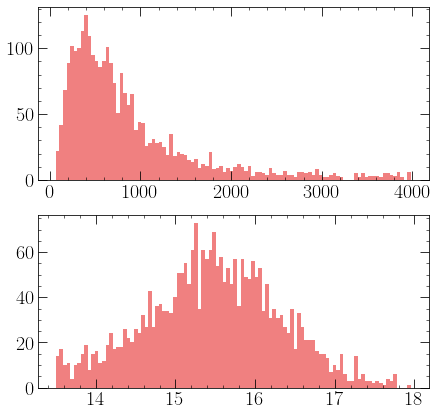

In [15]:
fig, ax = plt.subplots(2)

ax[0].hist(unwise['flux_1'][ex_mw], bins=100);
ax[1].hist(unwise['w1_mag'][ex_mw], bins=100);

In [34]:
#Color cuts to PHATTER sample following criteria from Goldman, et al 2022

phatter.select('(((F160W_VEGA < 19.48) & (F110W_VEGA - F160W_VEGA < 1.15)) | '
               '((F110W_VEGA - F160W_VEGA >= 1.15) & (F160W_VEGA < 2 * (F110W_VEGA - F160W_VEGA) + 17.18))) &'
               'IR_GST', 
               name='COL_CUT')

In [17]:
#Add index to PHATTER dataframe
phatter['INDEX'] = np.arange(len(phatter))

In [18]:
###Add 110-160 color column to dataframe for convenience
phatter['F110W_F160W'] = phatter['F110W_VEGA'] - phatter['F160W_VEGA']

# Color Conversion

In [44]:
# Read in the ALLWISE catalog
allwise = pd.read_csv('./allwise_p3as_psd_bright.stars.tbl',
                   delim_whitespace=True,
                   skiprows=range(0,44),
                   names=['id','ra','dec','w1','w1sig','w2','w2sig','w3','w3sig','w4','w4sig','j','h'])

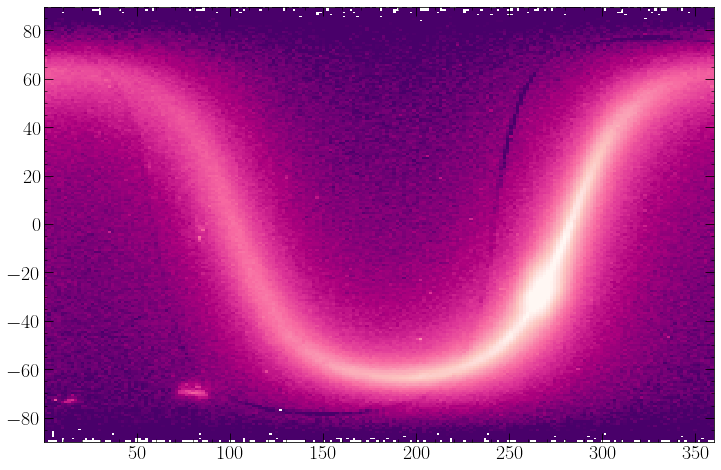

In [40]:
plt.figure(figsize=(12,8))

dmap = plt.hist2d(allwise['ra'],allwise['dec'],
                  bins=200,
                  norm=mpl.colors.LogNorm(vmin=10,vmax=1e4),
                 cmap='RdPu_r')

In [45]:
#Cut out all sources with no W1, J, or H 
#and exclude the most dense regions of the histogram
#to mitigate the effects of dust on the color locus

ind = ri.get_indices(dmap,allwise['ra'],allwise['dec'])
gd, = np.where( ~np.isnan(allwise['w1']) &
                ~np.isnan(allwise['j']) & ~np.isnan(allwise['h']) &
                (dmap[0].ravel()[ind]>=30) & (dmap[0].ravel()[ind]<300) )

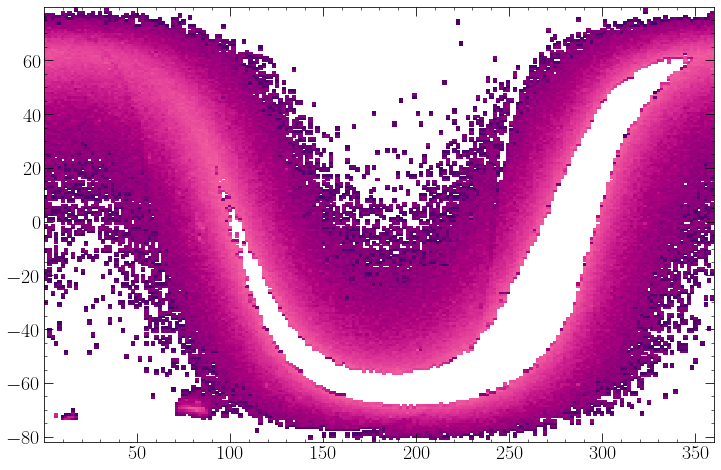

In [47]:
plt.figure(figsize=(12,8))

dmap2 = plt.hist2d(allwise['ra'][gd],allwise['dec'][gd],
                   bins=200,
                   norm=mpl.colors.LogNorm(vmin=10,vmax=1e4))

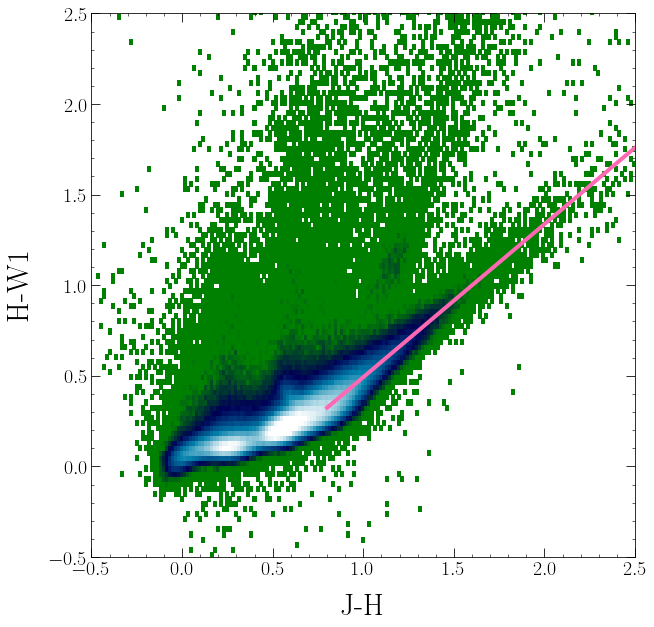

In [86]:
jhcol = np.asarray(allwise['j'][gd]-allwise['h'][gd])
hw1col = np.asarray(allwise['h'][gd]-allwise['w1'][gd])

fig,ax = plt.subplots()
fig.set_size_inches(10,10)

jhbins,hw1bins = np.arange(-0.5,2.5,0.02),np.arange(-0.5,2.5,0.02)
colcol = ax.hist2d(jhcol,hw1col,
                   bins=[600,600],
                   norm=mpl.colors.LogNorm(vmin=10,vmax=1e4),
                   cmap='ocean'
                  )

ax.set_aspect(1)
ax.set_xlabel('J-H')
ax.set_ylabel('H-W1')
ax.set_xlim(-0.5,2.5)
ax.set_ylim(-0.5,2.5)

ind = ri.get_indices(colcol,jhcol,hw1col)
wh, = np.where( (colcol[0].ravel()[ind]>=50) & (jhcol>1) )

def line(x,m,b):
    return m*x+b
p,cov = curve_fit(line,jhcol[wh],hw1col[wh])

x = np.linspace(0.8,2.5,1000)
ax.plot(x,line(x,*p),'hotpink', linewidth=4)

In [72]:
col_data = np.array([jhcol, hw1col])
col_kde = gaussian_kde(col_data)
X,Y = np.meshgrid(np.linspace(-0.5,2.5,100), np.linspace(-0.5,2.5,100))
points = np.vstack([X.ravel(), Y.ravel()])

In [60]:
%time
z = col_kde(points)

CPU times: user 5 µs, sys: 8 µs, total: 13 µs
Wall time: 21 µs


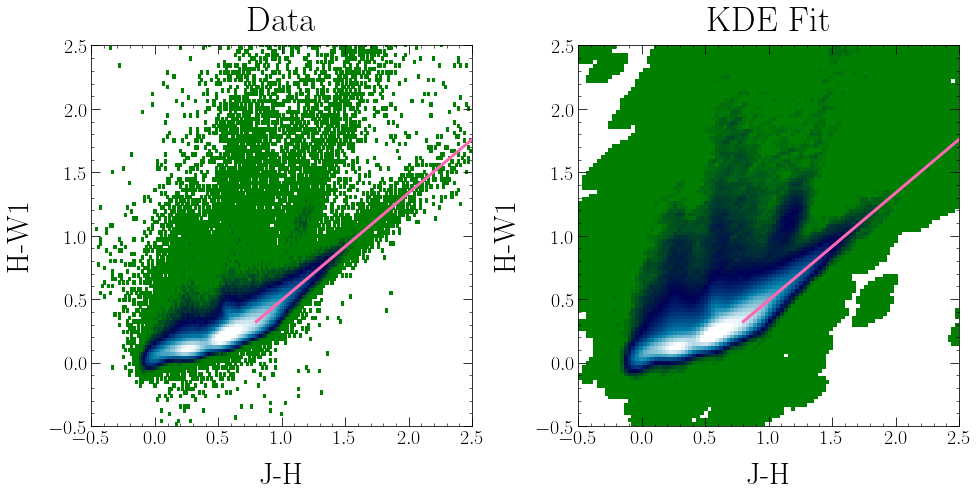

In [92]:
Z = np.reshape(z, X.shape)

fig, ax = plt.subplots(1,2)
fig.set_size_inches(16,7)

ax[0].set_aspect(1)
ax[0].hist2d(jhcol,hw1col,bins=[600,600],
             norm=mpl.colors.LogNorm(vmin=10,vmax=1e4),
             cmap='ocean'
            )
ax[0].set_xlim(-0.5,2.5)
ax[0].set_ylim(-0.5,2.5)
ax[0].set_title('Data');
ax[0].set_xlabel('J-H');
ax[0].set_ylabel('H-W1');

ax[1].imshow(np.flipud(Z), 
             norm=mpl.colors.LogNorm(vmin=0.001,vmax=10),
             cmap='ocean',
             extent=[-0.5,2.5,-0.5,2.5]
            )
ax[1].set_title('KDE Fit');
ax[1].set_xlabel('J-H');
ax[1].set_ylabel('H-W1');

x = np.linspace(0.8,2.5,1000)
ax[0].plot(x,line(x,*p),'hotpink', linewidth=3);
ax[1].plot(x,line(x,*p),'hotpink', linewidth=3);

plt.savefig('./images/color_locus.png', bbox_inches='tight')

In [93]:
###F160W to H conversion (using color conversions from https://arxiv.org/pdf/1109.6893.pdf (Dalcanton, 2018))
def convert_to_JH(f110w,f160w):
    j_h = 0.9418 + 0.841*(f110w-f160w-1.0) - 0.9053*(f110w-f160w-1.0)**2
    return j_h
def HST_to_2MASS(f110w,f160w):
    f160w_h = 0.2031 + 0.401*(convert_to_JH(f110w,f160w) - 0.9) + 0.3498*(convert_to_JH(f110w,f160w) - 0.9)**2
    h = f160w - f160w_h
    j = h + convert_to_JH(f110w,f160w)
    return j,h

###Define J and H for ph_data sources and add to dataframe

j_mag, h_mag = HST_to_2MASS(phatter['F110W_VEGA'], phatter['F160W_VEGA'])

phatter['J_Mag'], phatter['H_Mag'], phatter['J_H'] = j_mag, h_mag, j_mag - h_mag


###Convert J-H to H-W1 using parameters from fit (see Color_Conversion.ipynb), then get W1 mags for PHATTER sources
m_fit, b_fit = 0.84805331, -0.35556147

phatter['H_W1'] = m_fit*phatter['J_H'] + b_fit

phatter['W1_Mag'] = phatter['H_Mag'] - phatter['H_W1']

###Convert W1 magnitude to flux and add column to data
def m_to_flux(mag):
  result = 10**((mag - 22.5) / (-2.5))
  return result

phatter['W1_Flux'] = m_to_flux(phatter['W1_Mag'])

AttributeError: 'Hdf5MemoryMapped' object has no attribute 'F110W_F160W'

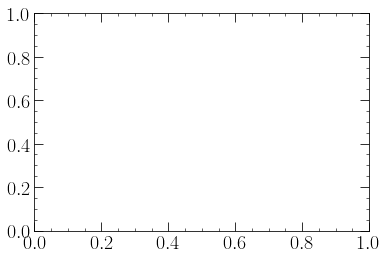

In [94]:
fig, ax = plt.subplots(1)

ax.scatter(phatter.F110W_F160W.evaluate(selection='COL_CUT'), phatter.F160W_VEGA.evaluate(selection='COL_CUT'),
          s=1.5)

ax.set_title('HST Sources (Goldman 2022 Color Cut)', fontsize=14)
ax.set_xlabel('F110W - F160W', fontsize=15)
ax.set_ylabel('F160W Magnitude')
ax.set_ylim(22,14);
ax.set_xlim(0,2.5);

#plt.savefig('goldman_cut.png', bbox_inches='tight')

In [21]:
x1 = np.linspace(-1.0, 1.14, 1000)
x2 = np.linspace(1.16, 2.5, 1000)
y1 = np.repeat(19.48, 1000)
y2 = 2 * x2 + 17.18

In [22]:
xs = np.concatenate((x1,x2), axis=0)
ys = np.concatenate((y1,y2), axis=0)

In [23]:
xg1 = np.linspace(-1.0, 1.2, 1000)
xg2 = np.linspace(1.2, 2.5, 1000)
yg1 = np.repeat(19.28, 1000)
yg2 = 2 * xg2 + 16.88

In [24]:
gxs = np.concatenate((xg1,xg2), axis=0)
gys = np.concatenate((yg1,yg2), axis=0)

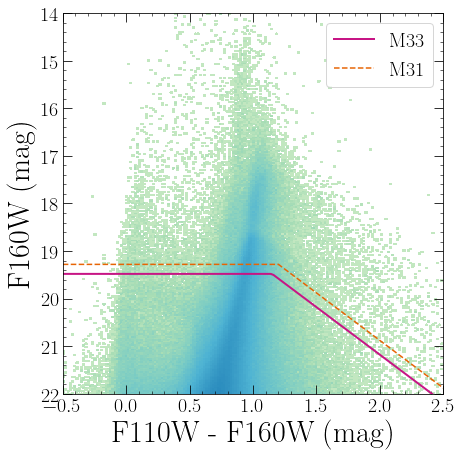

In [25]:
fig, ax = plt.subplots(1)

ax.set_aspect(3/8)


cmd = ax.hist2d(phatter.F110W_F160W.evaluate(selection='IR_GST'), phatter.F160W_VEGA.evaluate(selection='IR_GST'),
          bins=400,
          norm=mpl.colors.LogNorm(vmin=1e-2,vmax=1e5), 
          cmap='GnBu')
ax.plot(xs, ys, c='mediumvioletred', linestyle='-', linewidth=2, 
        label='M33' 
       )

ax.plot(gxs, gys, c='#E76404', linestyle='--', linewidth=1.5, 
        label='M31'
       )

ax.set_xlabel('F110W - F160W (mag)')
ax.set_ylabel('F160W (mag)')
ax.set_ylim(22,14)
ax.set_xlim(-0.5,2.5)

ax.legend(loc='best');

plt.savefig('goldman_cut.png', bbox_inches='tight')

In [182]:
m33_ar

0.7632386326836224

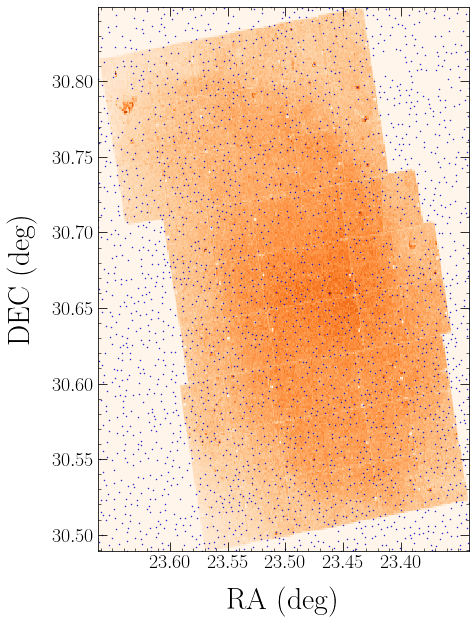

In [217]:
fig, ax = plt.subplots(1)
fig.set_size_inches(12,10)

ax.set_aspect(m33_ar)

cmap = plt.cm.get_cmap('Oranges')
hist = ax.hist2d(phatter.RA.evaluate(selection='IR_GST'), phatter.DEC.evaluate(selection='IR_GST'), 
          bins=300,
          cmap=cmap,
          vmin=1, vmax=4e2
                 
         )
ax.scatter(unwise['ra'], unwise['dec'], s=0.2, marker='o', c='mediumblue')
ax.set_xlim(phatter.RA.max(), phatter.RA.min())
ax.set_xticks([23.4, 23.45, 23.5, 23.55, 23.6])
#ax.set_ylim(phatter.DEC.min(), phatter.DEC.max())
ax.set_xlabel('RA (deg)')
ax.set_ylabel('DEC (deg)');

plt.savefig('./images/wise_overlay.png', bbox_inches='tight')

In [28]:
###PHATTER RA and DEC
###This is for the entire dataset with no selection, every PHATTER source will have a bin number
xp, yp = phatter.RA.evaluate(), phatter.DEC.evaluate()

###unWISE RA and DEC
xu, yu = unwise['ra'], unwise['dec']

In [29]:
(np.max(xu) - np.min(xu)) / (3/3600)

395.34601200000026

In [30]:
ra_bins = np.linspace(np.min(xu), np.max(xu), 395)
dec_bins = np.linspace(np.min(yu), np.max(yu), 395)

In [31]:
histp, hy, hx= np.histogram2d(yp, xp, bins=[ra_bins, dec_bins])
histu,_,_ = np.histogram2d(yu, xu, bins=[hy, hx])

In [32]:
###Get bin numbers for both PHATTER and unWISE sources
indp = ri.get_indices(histp, xp, yp, x_bins=ra_bins, y_bins=dec_bins)


In [33]:
indu = ri.get_indices(histu, xu, yu, x_bins=ra_bins, y_bins=dec_bins)

In [34]:
###Add bin numbers to data for convenience
unwise['bin'], phatter['BIN'] = indu, indp

In [35]:
np.max(indp), np.max(indu)

(151408, 155233)

In [36]:
indu[400:418]

array([92302, 92320, 92600, 93055, 93793, 93487, 93479, 93908, 95795,
       95111, 95103, 95442, 95478, 95779, 96275, 96555, 96534, 96624])

In [37]:
b = 92302
p, = np.where(indp == b)
u, = np.where(indu == b)
u, p[:5]

(array([400]), array([9235801, 9237357, 9237525, 9240350, 9241868]))

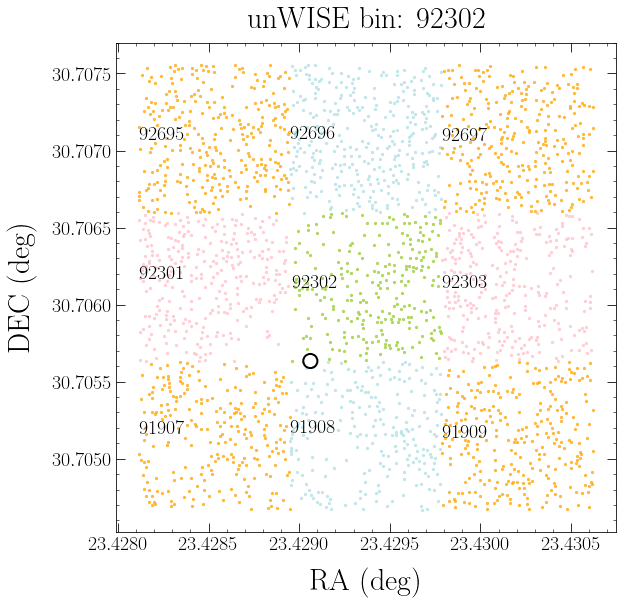

In [218]:
###Check that bin numbers are correctly aligned between the datasets
fig, ax = plt.subplots(1)
fig.set_size_inches(9,9)

u = 400
bins = 395

ax.set_aspect(0.85)

ax.set_xlabel('RA (deg)')
ax.set_ylabel('DEC (deg)')
ax.set_title('unWISE bin: ' + str(unwise['bin'][u]), fontsize=30)

ax.scatter(unwise['ra'][u], unwise['dec'][u], 
           edgecolor='black', 
           facecolor='none', 
           marker='o',
           s=200,
           zorder=5,
           linewidths=2
          )

uw = unwise['bin'][u]
bins = [uw, uw+1, uw-1, uw + bins - 1, uw - bins + 1, uw + bins, uw - bins, uw + bins - 2, uw - bins + 2]
cols = ['yellowgreen', 'pink', 'pink', 'powderblue', 'powderblue', 'orange', 'orange', 'orange', 'orange']

for i,bin in enumerate(bins):
    lox, = np.where(phatter.BIN.evaluate() == bins[i])
    ax.scatter(phatter.RA.evaluate()[lox], phatter.DEC.evaluate()[lox],
               color=cols[i], s=5, alpha=0.7)

    ax.text(np.min(phatter.RA.evaluate()[lox]), 
                np.mean(phatter.DEC.evaluate()[lox]),
                str(bins[i]), fontsize=20)
    

    
plt.savefig('./images/bin_visuals.png', bbox_inches='tight')

In [39]:
hst_bins = phatter.BIN.evaluate(selection='COL_CUT')
RA, DEC = phatter.RA.evaluate(selection='COL_CUT'), phatter.DEC.evaluate(selection='COL_CUT')
hst_index = phatter.INDEX.evaluate(selection='COL_CUT')

In [40]:
%%time
###Create an array the length of the PHATTER dataframe of strings the length of the unWISE objectID
match_ids = np.asarray(['****************'] * len(phatter.RA.evaluate()))
ph_ind = []

###Number of bins should match the number chosen for reverse indices above
bins = 395

for i,source in enumerate(unwise):
    ###Get bin of unWISE source
    wb = unwise['bin'][i]
    ###Get indices of PHATTER sources in the same or nearby bins
    loc, = np.where((hst_bins >= wb - bins) & (hst_bins <= wb + bins))
     
    ###Get the distance between each PHATTER source and the unWISE source
    dist = np.sqrt( ((RA[loc] - unwise['ra'][i])*np.cos(unwise['dec'][i] * np.pi / 180))**2 
                   + (DEC[loc] - unwise['dec'][i])**2)
    
    ###Get indices of PHATTER sources where the above distance is 3" or less                                                                                                                                              
    matched, = np.where(dist <= 3/3600)
    ###Add the objid of the unWISE source 
    ###to the array of match IDs at the index of each matched PHATTER source
    if len(matched) != 0:
        ind = hst_index[loc][matched]
        ph_ind.append(ind)

        match_ids[ind] = unwise['unwise_objid'][i]
               
    else:
        ph_ind.append([])

CPU times: user 4.26 s, sys: 502 ms, total: 4.76 s
Wall time: 4.73 s


In [41]:
match, = np.where(match_ids != '****************')
n = 6
###Get the first n unwise object IDs for sources that have matches
first_n = np.unique(match_ids[match])[:n]

In [42]:
w1f = phatter.W1_Flux.evaluate(selection='COL_CUT')
col = phatter.F110W_F160W.evaluate(selection='COL_CUT')
pds = phatter.INDEX.evaluate(selection='COL_CUT')

<string>:1: RuntimeWarning: overflow encountered in power


In [136]:
import cmasher

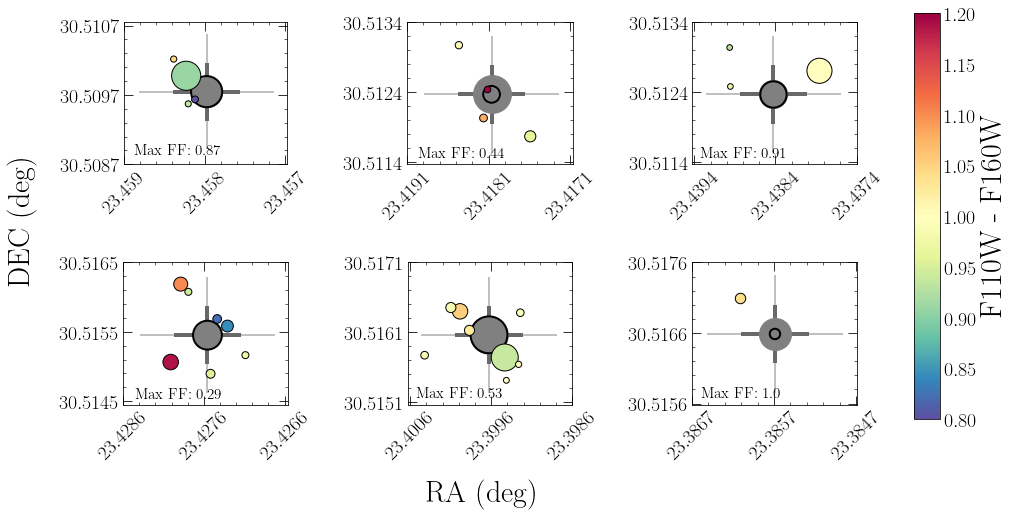

In [166]:
fig, axs = plt.subplots(2,3, figsize=(12,6))
fig.tight_layout(h_pad=7)

dec_m33 = 30.66
aspect_ratio = np.cos(np.pi/180.*dec_m33)

for i,ax in enumerate(axs.ravel()[:n]):
 ob, = np.where(unwise['unwise_objid'] == first_n[i])
 ph, = np.where(match_ids[pds] == first_n[i])
    
 match_flux = w1f[ph]
 total_flux = np.sum(w1f[ph])
 wise_flux = unwise['flux_1'][ob]
 colors_match = col[ph]
 color_wise = unwise[ob]['w1_mag'] - unwise[ob]['w2_mag']
 cmh = cmasher.get_sub_cmap('Spectral_r', 0.0, 1.0)
 cmw = cmasher.get_sub_cmap('winter', 0.0, 1.0)#plt.cm.get_cmap('Purples_r')
 ordered = np.argsort(match_flux)[::-1]
 max_ff = (match_flux[ordered][0] / total_flux).round(2)
    
    

 ax.errorbar(unwise[ob]['ra'], unwise[ob]['dec'], 
              xerr=(3/3600), yerr=(3/3600), 
            color='silver', 
            linewidth=2)
 ax.errorbar(unwise[ob]['ra'], unwise[ob]['dec'], 
              xerr=(1.5/3600), yerr=(1.5/3600), 
            color='dimgrey', 
            linewidth=4)
 ax.scatter(unwise[ob]['ra'], unwise[ob]['dec'], 
           s=total_flux, 
           edgecolors='black', 
           linewidth=2, 
           facecolors='none', 
           marker='o',  
           label='Total Flux of Matches', 
           zorder=6)
 wplot = ax.scatter(unwise[ob]['ra'], unwise[ob]['dec'], 
           s=wise_flux,
           c='grey',
           #c=color_wise,
           # cmap=cmw,
           #         vmin=-0.9, vmax=0.75,
           label='WISE Source', 
           zorder=5)
 cplot = ax.scatter(RA[ph], 
                   DEC[ph], 
                     s=match_flux, 
                     edgecolors='black', 
                     c=colors_match, 
                     cmap=cmh, 
                     vmin=0.8, vmax=1.2, 
                     label='HST Matches', 
                     zorder=7)
    
 x,y = unwise[ob]['ra'], unwise[ob]['dec']
 ax.set_xlim(x+0.001, x-0.001)
 ax.set_xticks([x.round(4)-0.001, x.round(4), x.round(4)+0.001])
 ax.set_ylim(y-0.001, y+0.001)
 ax.set_yticks(([y.round(4)-0.001, y.round(4), y.round(4)+0.001]))
 ax.ticklabel_format(useOffset=False)
 ax.tick_params(axis='x', labelrotation=45)


 ax.text(x+0.0009, y-0.0009, 'Max FF: ' + str(max_ff), fontsize=15)
 ax.set_aspect(aspect_ratio)
# end of loop

hst_cax = fig.add_axes([1.0, 0.04, 0.03, 0.94])
hst_cbar = fig.colorbar(cplot, cax=hst_cax)
hst_cbar.ax.tick_params(which='both', size=0)
hst_cbar.set_label('F110W - F160W')

#wise_cax = fig.add_axes([1.15, 0.04, 0.03, 0.94])
#wise_cbar = fig.colorbar(wplot, cax=wise_cax)
#wise_cbar.ax.tick_params(size=0)
#wise_cbar.set_label('W1 - W2')

fig.text(0.5, -0.15, 'RA (deg)', horizontalalignment='center', fontsize=30);
fig.text(-0.05, 0.5, 'DEC (deg)', rotation='vertical', verticalalignment='center', fontsize=30);

plt.savefig('cutout_plots.png', bbox_inches='tight')

In [ ]:
from astropy.table import Table

In [ ]:
###Create table with index of the PHATTER data and the objid of the wise source it matched to

objid_key = Table([phatter.INDEX.evaluate(), match_ids], names=['phatter_index', 'unwise_objid'])

In [ ]:
m, = np.where(objid_key['unwise_objid'] != '****************')

In [ ]:
#objid_key[m].write('objid_key.csv')
